In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope

import mlflow
import mlflow.lightgbm

import sys
import os
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/src')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/utils')

#from src.lightgbm_model_v3 import lightgbm_dev
from src.lightgbm_model import *
from utils.metrics import *
from utils.plots import *
from utils.model_io import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path

['/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/venv1/lib/python3.9/site-packages',
 '/Users/ben/Desktop/py_proj/account_funds_prediction',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/src',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/utils']

In [3]:
os.getcwd()

'/Users/ben/Desktop/py_proj/account_funds_prediction/notebook'

## 1. Data prep

In [4]:
df = pd.read_csv('/Users/ben/Desktop/py_proj/account_funds_prediction/data/df.csv')

In [5]:
df.head()

,id,funds_now,funds_after_6months,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
0,1,580888.6,411571.0,69,44,443,158191,211023.6,13320.2,11516.5,...,10232.7,26721.0,39983.1,45532.4,11885.7,1,1,1,0,1
1,2,372438.7,157944.4,32,43,496,208050,19841.3,45983.3,119858.9,...,-26726.7,-19164.4,22911.3,-9997.3,3621.1,1,0,0,0,0
2,3,645639.9,22235.5,89,55,527,148731,854416.8,41016.9,31300.6,...,-15244.7,4683.6,32100.5,-32710.4,39201.2,1,1,1,1,0
3,4,1191515.2,316512.4,78,1,628,263843,850936.3,2612.9,73886.1,...,18567.4,28572.1,-44307.5,-43039.7,156.0,1,1,1,1,0
4,5,348260.8,0.0,38,16,764,264430,979270.8,5583.3,252329.3,...,-15909.1,-33315.5,-32351.8,15200.4,-7349.3,0,0,1,1,0


In [6]:
df.shape

(200000, 52)

In [7]:
# train test split
X = df.drop(columns=['funds_after_6months', 'id'])
y = df['funds_after_6months']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## 2. Baseline Model

In [8]:
baseline_params = {
    'max_depth': 3,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.5
}

search_space = {
    # Integer parameters
    'max_depth': scope.int(hp.quniform('max_depth', 3,10,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50,300,50)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 100, 5)),  
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 5, 100, 5)),  

    # Decimal parameters
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),  # Typical range for learning rate
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0),  # Typical range for feature_fraction
    'bagging_fraction': hp.uniform('bagging_fraction', 0.3, 1.0),  # Typical range for bagging_fraction
    'lambda_l1': hp.uniform('lambda_l1', 0, 1),  # Typical range for lambda_l1 (L1 regularization)
}


In [9]:
lgb_dev1 = lightgbm_dev_v4(X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test,
                   baseline_params = baseline_params,
                   baseline_ind=1,
                   max_evals=2,
                   loss_function = 'power_ratio',
                   search_space=search_space)

In [10]:
lgb_dev1

In [11]:
lgb1 = lgb_dev1.run_model()

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10335
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 50
[LightGBM] [Info] Start training from score 177372.881641
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


2025/01/11 12:16:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: decdb7c6d1e8410d963fadfedd72190d


In [12]:
lgb1

(LGBMRegressor(feature_fraction=0.5, max_depth=3, n_estimators=50),
 'decdb7c6d1e8410d963fadfedd72190d')

In [13]:
lgb1_id = lgb1[1]
lgb1_id

'decdb7c6d1e8410d963fadfedd72190d'

In [14]:
# Fetch the run details using MLflow API
run = mlflow.get_run(lgb1_id)

# Retrieve the metrics from the run
rmse_train = run.data.metrics.get("rmse_train", None)
rmse_test = run.data.metrics.get("rmse_test", None)
r2_train = run.data.metrics.get("r2_train", None)
r2_test = run.data.metrics.get("r2_test", None)
pr_train = run.data.metrics.get("powerratio_train", None)
pr_test = run.data.metrics.get("powerratio_test", None)

# Print the retrieved metrics
print(f"RMSE Train: {rmse_train}")
print(f"RMSE Test: {rmse_test}")
print(f"R2 Train: {r2_train}")
print(f"R2 Test: {r2_test}")
print(f"Power Ratio Train: {pr_train}")
print(f"Power Ratio Test: {pr_test}")

RMSE Train: 89797.37195508531
RMSE Test: 88598.92600274534
R2 Train: 0.8255338855969169
R2 Test: 0.8293940009814278
Power Ratio Train: 0.9398507959736816
Power Ratio Test: 0.9390895402733672


## 3. HyperOpt (32 fits)

In [15]:
lgb_dev2 = lightgbm_dev_v4(X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test,
                   baseline_params = baseline_params,
                   baseline_ind=0,
                   loss_function = 'power_ratio',
                   max_evals=32,
                   search_space=search_space)

In [16]:
%%time
lgb2 = lgb_dev2.run_model()

[LightGBM] [Warning] lambda_l1 is set=0.012837454013601146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012837454013601146                                                                                           
[LightGBM] [Warning] feature_fraction is set=0.31353111276482853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31353111276482853                                                                        
[LightGBM] [Warning] bagging_fraction is set=0.6626110122283606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626110122283606                                                                                 
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20                                                                                                          
[LightGBM] [Warning] lambda_l1 is set=0.012837454013601146, reg_alpha=0.0 will be ignore

2025/01/11 12:17:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: f2e1b5d820074d218119e6d9f10d56e7
best param: {'num_leaves': 25, 'max_depth': 6, 'n_estimators': 100, 'min_data_in_leaf': 90, 'learning_rate': 0.0693119081547633, 'feature_fraction': 0.9866238205657614, 'bagging_fraction': 0.4399037504238241, 'lambda_l1': 0.1899773213439921}
CPU times: user 5min 29s, sys: 1min 46s, total: 7min 16s
Wall time: 1min 11s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [17]:
lgb2

(LGBMRegressor(bagging_fraction=0.4399037504238241,
               feature_fraction=0.9866238205657614, lambda_l1=0.1899773213439921,
               learning_rate=0.0693119081547633, max_depth=6,
               min_data_in_leaf=90, num_leaves=25),
 'f2e1b5d820074d218119e6d9f10d56e7')

In [18]:
# Fetch the run details using MLflow API
run_id = lgb2[1]
run = mlflow.get_run(run_id)

# Retrieve the metrics from the run
rmse_train = run.data.metrics.get("rmse_train", None)
rmse_test = run.data.metrics.get("rmse_test", None)
r2_train = run.data.metrics.get("r2_train", None)
r2_test = run.data.metrics.get("r2_test", None)
pr_train = run.data.metrics.get("powerratio_train", None)
pr_test = run.data.metrics.get("powerratio_test", None)

# Print the retrieved metrics
print(f"RMSE Train: {rmse_train}")
print(f"RMSE Test: {rmse_test}")
print(f"R2 Train: {r2_train}")
print(f"R2 Test: {r2_test}")
print(f"Power Ratio Train: {pr_train}")
print(f"Power Ratio Test: {pr_test}")

RMSE Train: 84909.15333104599
RMSE Test: 85232.3588566585
R2 Train: 0.8440114014319899
R2 Test: 0.8421129903561289
Power Ratio Train: 0.9422371333791886
Power Ratio Test: 0.9406367448883353


## 4. Save the best HyperOpt model

In [19]:
lgb_model = lgb2[0]
lgb_model

LGBMRegressor(bagging_fraction=0.4399037504238241,
              feature_fraction=0.9866238205657614, lambda_l1=0.1899773213439921,
              learning_rate=0.0693119081547633, max_depth=6,
              min_data_in_leaf=90, num_leaves=25)

In [20]:
save_model(lgb_model, "lgb_model_v3.pkl", "/Users/ben/Desktop/py_proj/account_funds_prediction/models")

Model saved to /Users/ben/Desktop/py_proj/account_funds_prediction/models/lgb_model_v3.pkl


In [21]:
# test reading the pkl file
model_test = load_model("lgb_model_v3.pkl", "/Users/ben/Desktop/py_proj/account_funds_prediction/models")

Model loaded from /Users/ben/Desktop/py_proj/account_funds_prediction/models/lgb_model_v3.pkl


In [22]:
model_test

LGBMRegressor(bagging_fraction=0.4399037504238241,
              feature_fraction=0.9866238205657614, lambda_l1=0.1899773213439921,
              learning_rate=0.0693119081547633, max_depth=6,
              min_data_in_leaf=90, num_leaves=25)

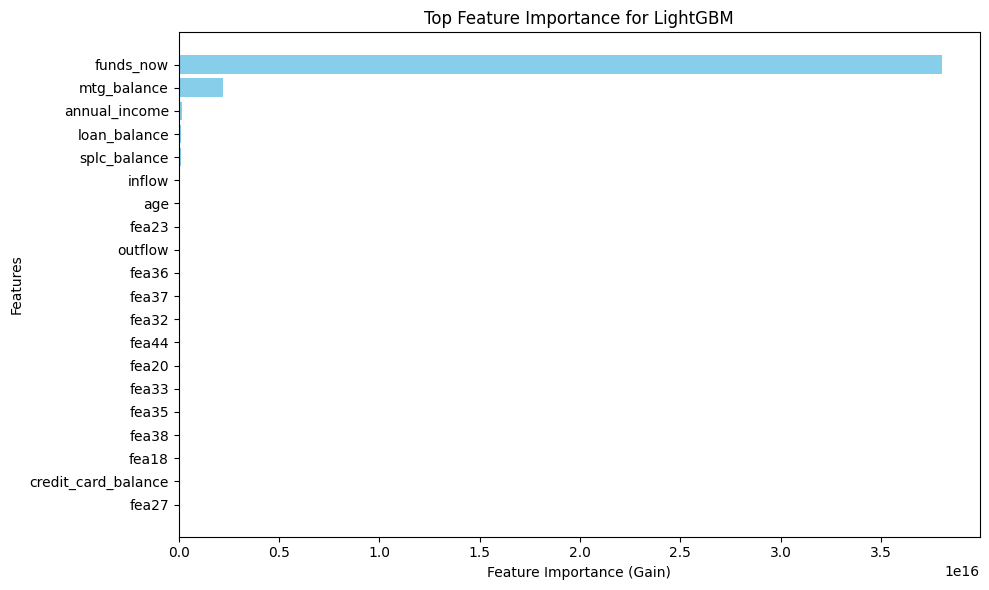

In [23]:
## feature importance
fea_imp_lgb(lgb_model)